Задание Ultra Lite
Перепишите генеративную сеть для Mnist “с нуля”, в новом ноутбуке для:

* Разных batch_size (512,16) 

* Разных комбинаций: сильный генератор-слабый дискриминатор, слабый генератор-сильный дискриминатор и т.д.

Можно подсматривать в ноутбук занятия, но крайне желательно писать код своими руками, а не копировать.

In [ ]:
Подключение библиотек
from keras.datasets import mnist, cifar10 Mnist - набор рукописных цифр, cifar10 - изображения объектов 1-ти классов
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv2DTranspose, Activation, MaxPooling2D, GlobalMaxPooling2D, concatenate, Embedding, multiply Базовые слои keras
from keras.layers.advanced_activations import LeakyReLU LeakyReLU - функция активации
from keras.layers.convolutional import UpSampling2D, Conv2D Сверточные слои keras
from keras.models import Model Формат модели keras
from tensorflow.keras.optimizers import Adam, RMSprop Оптимизатор 

import tensorflow as tf

import matplotlib.pyplot as plt Отображение графиков

import numpy as np Numpy массивы

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Модель GAN на основе классов TensorFlow.
За основу была взята [документация TensorFlow](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit#wrapping_up_an_end-to-end_gan_example).<br>
Но с изменениями. Целью было разобраться в построении моделей на классах TensorFlow. Поэтому код обильно комментирован.

**Комментарий к модели.**

Для последовательной тренировки генератора и дискриминатора, необходимо подавать наборы данных в виде мини-пакетов (mini-batches). Проще всего это было сделать с помощью метода [dataset.from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices).

Использование этого подхода резко сокращает код и улучшает его читабельность. И увеличивает скорость выполнения.

После того, как мы решили задачу подготовки и подачи данных, переходим к построению модели.

Генератор и дискриминатор определены в отдельных функциях - геттерах. Можно было бы их реализовать как методы класса **Model**, но смысла нет. Также в таком варианте нет необходимости их компилировать отдельно.

При реализации модели на основе класса TensorFlow есть возможность кастомизировать различные фазы построения модели. Для практической реализации модели **GAN** на основе классов было бы вполне достаточно переопределить фазу .**FIT (метод train_step)**, однако было интересно понять, какие есть возможности при переопределении и других фаз.

В фазе **.COMPILE** можно определить отдельно для генератора и дискриминатора оптимизаторы, функции потерь и метрики.

**.compile(optimizers=optimizers, loss=loss, metrics=metrics)**

В качестве параметров для компиляции передаем словари с оптимизаторами, функциями потерь и метриками
**Оптимизаторы в виде словаря** (они могут быть различными для генератора и дискриминатора): 
```
optimizers = {
    "discriminator_optimizer": Adam(learning_rate=learning_rate),
    "generator_optimizer": RMSprop(learning_rate=learning_rate)}
```
**Словари для функций loss**.<br> Функция **Loss** может быть одинаковой для генератора и дискриминатора, но в некоторых случаях (**CGAN**) могут потребоваться и разные функции для них, поэтому оставляем в коде такую возможность.
Можно в качестве значения передать стандартную **TensorFlow** функцию, а можно и свою собственную.<br>
Для задачи **бинарной классификации** (у нас именно такая задача) будем использовать 
```tf.keras.losses.BinaryCrossentropy(from_logits= ХХ, ..)```
которая вычисляет кросс-энтропию между истинными лэйблами и предсказанными.<br>
```BinaryCrossentropy``` имеет параметр ```from_logits=False/True```.<br>
Если ```from_logits=False```, то предсказанное значение (y_pred) представляет собой вероятность, область значений [0,1].<br>
Если ```from_logits=True```, то предсказанное значение (y_pred) представляет лоджит (logit), область значений [-inf, + inf].<br>
Для оценки качества работы дискриминатора, мы сравниваем предсказанные им значения лейблов с истинными значениями.<br>
Дискриминатор имеет фукцию активации **sigmoid**, область значения которой **[0,1]**.<br>
Значения лейблов также лежат в области **[0,1]**.<br>
Для оценки качества работы генератора, мы передаем выданные им изображения в генератор, который выдает оценку, область значения которой **[0,1]**.<br>
С этой точки зрения, правильнее использовать **from_logits=True**, однако **документация TensorFlow** настоятельно рекомендует использовать вариант с **from_logits=True**.<br>
Поэтому в нашем случае для генератора и дискриминатора будем использовать параметр **from_logits=True**<br>
```loss = {
  "generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), 
  "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}```<br>
Для передачи в класс собственной функции потерь, можно передать предварительно определенную функцию таким образом: **"custom_loss_fn": my_loss_fn()**<br>
**Метрики передаем также в виде словаря.**<br>
В словаре можно в качестве значения передать стандартную **TensorFlow** метрику, а можно и свою собственную.<br>
Для собственных метрик, если требуется контроль метрик только для батча, можно обойтись просто определением функции<br>
```def metric_function(y_true, y_pred):
    ...
    metric_value =```<br>
Если требуется контроль метрик по всему датасету (то есть, за эпоху), собственную метрику нужно определять на основе класса<br>
```class MetricLayer(tf.keras.metrics.Metric)
    def __init__(self, name="MetricLayer", **kwargs):
        super(MetricLayer, self).__init__(name=name, **kwargs)
        self.metric = self.add_weight(name="Metric", initializer="zeros") ```<br>
и далее, определяем переменные треккеров:<br>```
loss_tracker = tf.keras.metrics.Mean(name="loss")
mae = tf.keras.metrics.MeanAbsoluteError(name="mae")
metrics = {"generator_loss": metric_fn, "discriminator_loss": tf.keras.metrics.Accuracy()}```
###Фаза FIT подробно откомментирована в коде
**Пример инициализации своего класса:**
```gan = MyGan(image_shape=(28,28,1), generator_type='strong', disciminator_type='weak', class_vector_shape, latent_dim=100)```<br>
**latent_dim** - размер вектора скрытого пространства, из которого создается изображение генератором

In [ ]:
class MyGan(Model):
  def __init__(self, image_shape, generator_type, disciminator_type, latent_dim, **kwargs):
    super(MyGan, self).__init__(**kwargs)
    self.latent_dim=latent_dim

    self.generator      = get_generator     (image_shape=image_shape, latent_dim=latent_dim, generator_type=generator_type)
    self.discriminator  = get_discriminator (image_shape=image_shape, disciminator_type=disciminator_type)
    
    self.discriminator_loss_fn  = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    self.generator_loss_fn      = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    # Инициализируем переменные трекеров функции ошибки как класс metrics.Mean, они будут считать среднее за эпоху
    # Далее, в методе metrics() мы их укажем в списке, чтобы они автоматически обнулялись в конце эпохи и при начале 'evaluate()'
    self.discriminator_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
    self.generator_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")

  # Фаза compile 
  def compile(self, optimizers, loss, metrics):
      super(MyGan, self).compile()
      self.discriminator_optimizer = optimizers["discriminator_optimizer"]  # Оптимизатор для дискриминатора, 
                                                                            # передаем в параметрах при вызове метода .compile в виде словаря
      self.generator_optimizer = optimizers["generator_optimizer"]          # Оптимизатор для генератора

      self.generator_loss_fn = loss["generator_loss_fn"]          # loss функция для генератора при генерации изображения
      self.discriminator_loss_fn = loss["discriminator_loss_fn"]  # loss функция для дискриминатора. Обе передаем в параметрах при вызове метода .compile в виде словаря

  # Фаза predict 
  def call(self, inputs):
    return self.generator(inputs) # При вызове MyGan.predict(x) отправляем на выполнение в generator(x).   
  
  # Фаза evaluate 
  def test_step(self, inputs):
    x, y = inputs
    y_ = self.generator(x) #  , training=False) не указываем, веса в нашем генераторе обновляются в методе train_step()
    generator_loss = self.generator_loss_fn(y, y_)
    self.generator_loss_tracker.update_state(generator_loss)
    return {"generator_loss": generator_loss, "metric": self.generator_loss_tracker.result()}

  @property  
  def metrics(self):
    # Возвращаем список переменных - метрик. 
    # Для указанных в списке метрик будет автоматически вызываться 
    'reset_states()' # в конце каждой эпохи или при запуске 'evaluate()'
    return [self.discriminator_loss_tracker, self.generator_loss_tracker]

  # Фаза fit 
  def train_step(self, data):
    if isinstance(data, tuple):
      real_images = data[0]
    else:
      real_images = data
    batch_size = tf.shape(data)[0]
    # Сгенерим вектора размером latent_dim по нормальному распределнию, сделаем их целую пачку размером batch_size
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    generated_images = self.generator(random_latent_vectors) # Генератором наделаем из них изображений
    combined_images = tf.concat([generated_images, real_images], axis=0) # Соберем их вместе с реальными изображениями
    # К пачке изборажений сделаем лейблы, где настоящие, а где случайные (сгенерированные) изображения
    # 1 - сгенерированные изображения, 0 - реальные изображения
    labels = tf.concat([tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],axis=0)
    labels += 0.05 * tf.random.uniform(tf.shape(labels)) #  Добавим немного (5%) шума в лейблы - такая хитрость, чтобы не было однозначного толкования
    # Используем равномерное распределение. В нашем случае, равная вероятность получения любого числа в дефолтном диапазоне 0,1 (не включая)

    # ================ Тренируем дискриминатор: ======================
    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)
      discriminator_loss = self.discriminator_loss_fn(labels, predictions)
    # Вычисляем градиенты    
    gradients = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
    # Обновляем веса
    self.discriminator_optimizer.apply_gradients(zip(gradients, self.discriminator.trainable_weights))


    # ================ Тренируем генератор: ======================
    # Веса дискриминатора здесь не обновляем, естественно.

    # Еще раз сгенерим вектора размером latent_dim по нормальному распределнию, сделаем их целую пачку размером batch_size
    random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))

    # Подсовываем генератору обманные лейблы к случайным векторам, в них говорим, что это реальные изображения
    # 1 - сгенерированные изображения, 0 - реальные изображения
    misleading_labels = tf.zeros((batch_size, 1))

    with tf.GradientTape() as tape:
      generated_images=self.generator(random_latent_vectors) # Генератор по предложенным ему случайным векторам создает избражения.
      predictions = self.discriminator(generated_images) # Дискриминатор проверяет их на достоверность
      # Считаем функцию ошибки между лейблами, которые отдал после проверки дискриминатор
      # и предложенными генератору обманными лейблами, где все изображения указаны как реальные
      # Чем лучше генератор создает изображения, которым, в свою очередь, верит дискриминатор,
      # тем меньше будет функция потерь. 
      # Но изображения будут хорошими, только если дискриминатор не лошара.
      generator_loss = self.generator_loss_fn(misleading_labels, predictions) 
    # Вычисляем градиенты  
    gradients = tape.gradient(generator_loss, self.generator.trainable_weights) # Считаем градиенты для генератора
    # Обновляем веса
    self.generator_optimizer.apply_gradients(zip(gradients, self.generator.trainable_weights)) # и отдаем их оптимизатору для back_propagation

    # Обновляем метрики
    self.generator_loss_tracker.update_state(generator_loss)
    self.discriminator_loss_tracker.update_state(discriminator_loss)
    # Возвращаем результаты обновления метрик. Они будут отбражаться в результатах обучения за эпоху.
    # В качестве класса трекера мы указали класс среднее (Mean), поэтому результаты будут усредняться
    return {"generator_loss": self.generator_loss_tracker.result(), "discriminator_loss": self.discriminator_loss_tracker.result()}

In [ ]:
# Подготовим набор данных. Будем использовать оба набора - training & test из 'MNIST digits'.
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
img_shape = (28, 28, 1) # Размерность входных данных для набора Mnist
latent_dim = 128 # Размерность скрытого пространства

#Разный размер батча

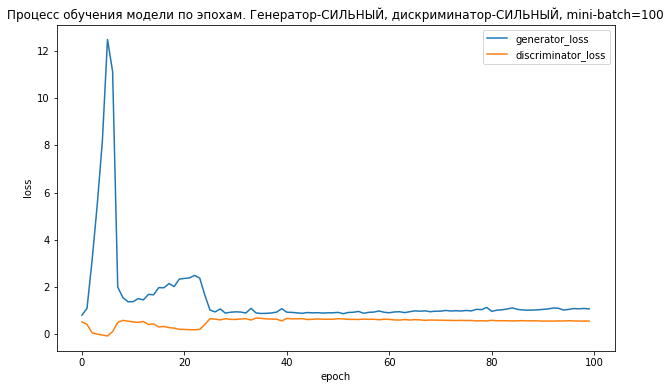

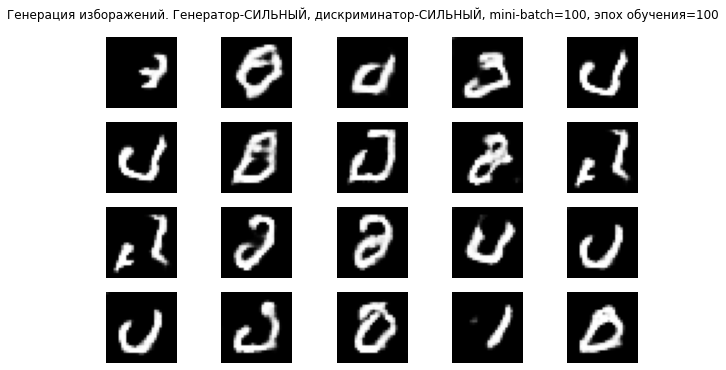

In [ ]:
mini_batch=100
epochs=100
gan=MyGan(image_shape=img_shape,generator_type='strong',disciminator_type='strong', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=epochs)

Epoch 1/30
512/512 [==============================] - 17s 29ms/step - generator_loss: 1.4428 - discriminator_loss: 0.4269
Epoch 2/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 1.2550 - discriminator_loss: 0.5083
Epoch 3/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 1.7188 - discriminator_loss: 0.3662
Epoch 4/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 0.8686 - discriminator_loss: 0.6806
Epoch 5/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 0.8755 - discriminator_loss: 0.6647
Epoch 6/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 0.8875 - discriminator_loss: 0.6579
Epoch 7/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 0.8608 - discriminator_loss: 0.6729
Epoch 8/30
512/512 [==============================] - 15s 29ms/step - generator_loss: 0.8624 - discriminator_loss: 0.6603
Epoch 9/30
512/512 [====

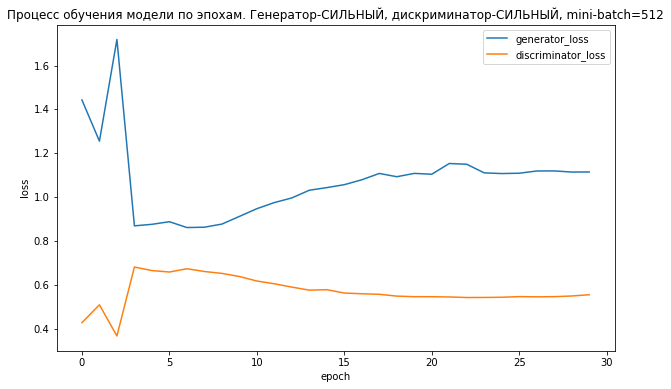

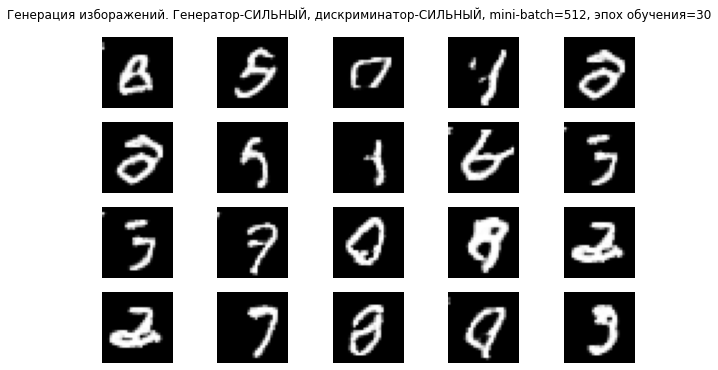

In [ ]:
mini_batch=512
epochs=30
gan=MyGan(image_shape=img_shape,generator_type='strong',disciminator_type='strong', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=True)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=epochs)

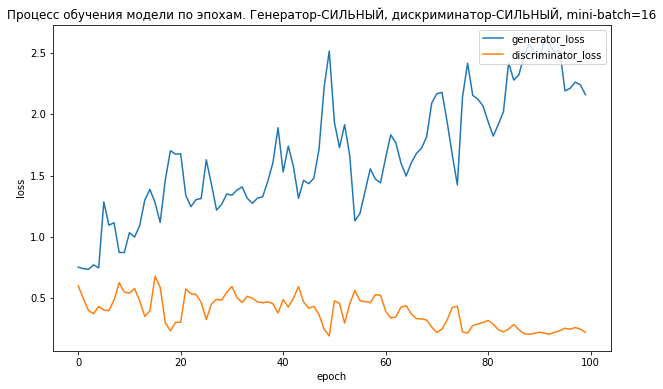

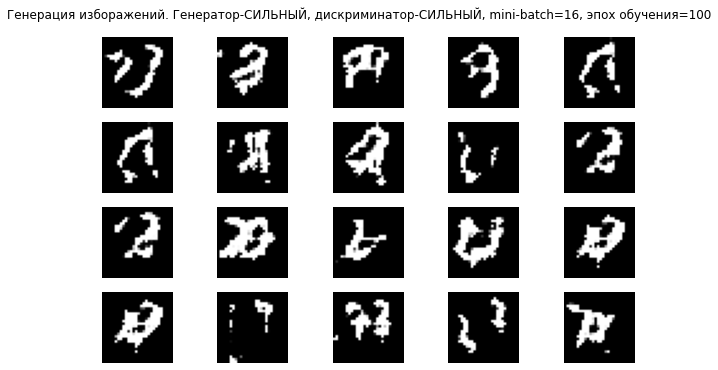

In [ ]:
mini_batch=16
epochs=100
gan=MyGan(image_shape=img_shape,generator_type='strong',disciminator_type='strong', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=epochs)

#Сильные/слабые генераторы и дискриминаторы

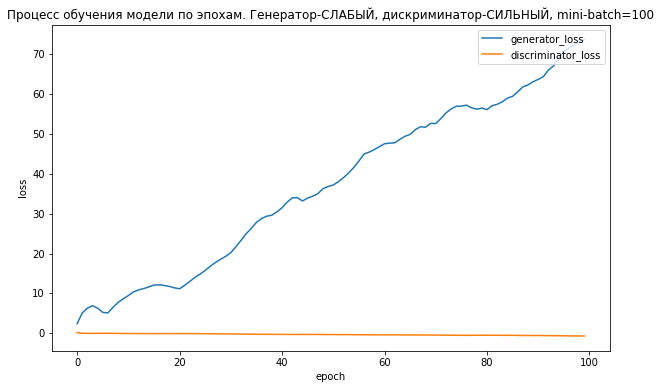

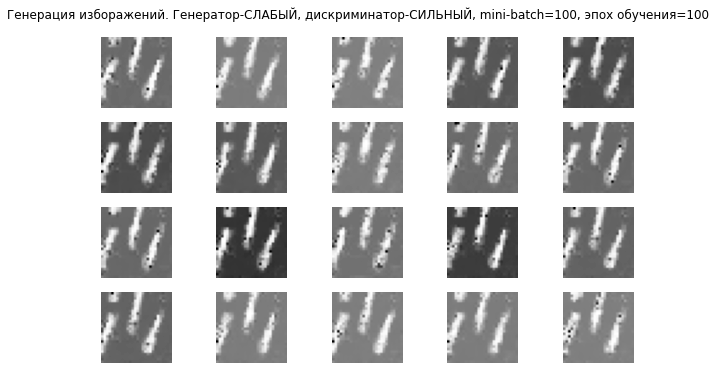

In [ ]:
gan=MyGan(image_shape=img_shape,generator_type='weak',disciminator_type='strong', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
mini_batch=100
epochs=100
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СЛАБЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=epochs)

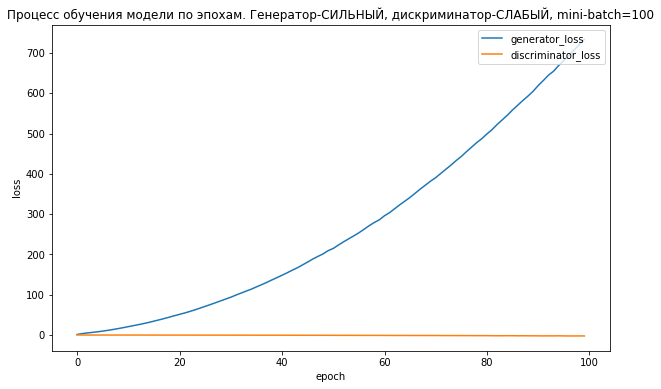

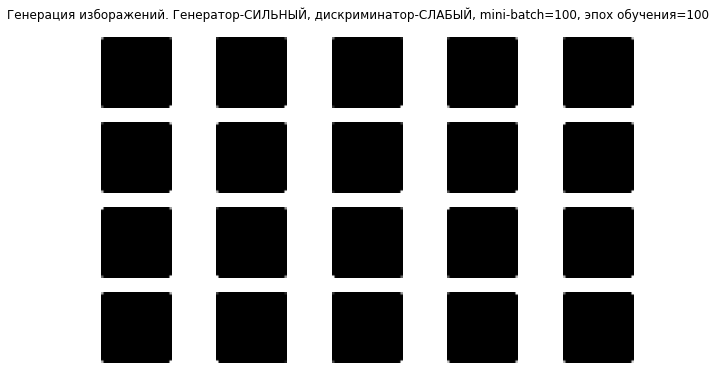

In [ ]:
gan=MyGan(image_shape=img_shape,generator_type='strong',disciminator_type='weak', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
mini_batch=100
epochs=100
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СЛАБЫЙ', batch_size=mini_batch, epochs=epochs)

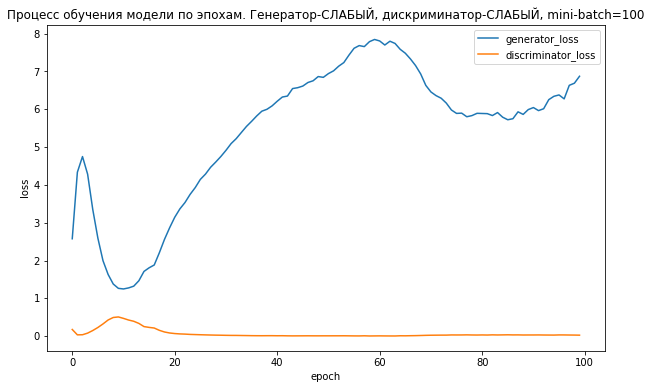

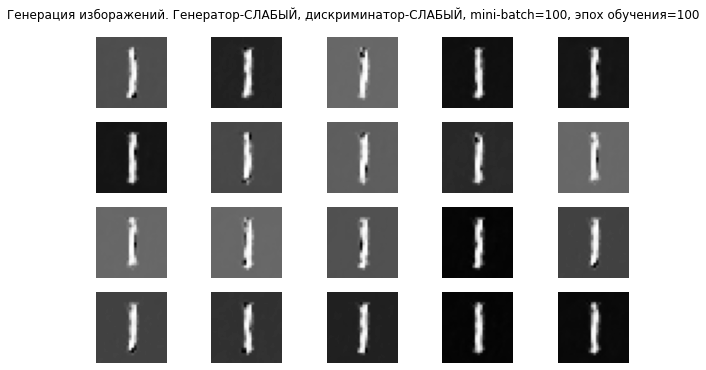

In [ ]:
gan=MyGan(image_shape=img_shape,generator_type='weak',disciminator_type='weak', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
mini_batch=100
epochs=100
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СЛАБЫЙ', discriminator_type='СЛАБЫЙ', batch_size=mini_batch, epochs=epochs)

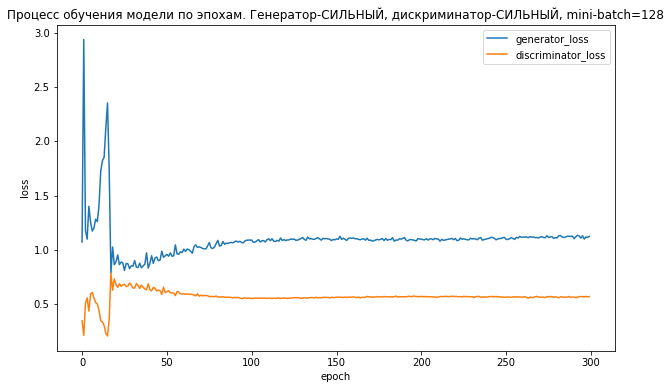

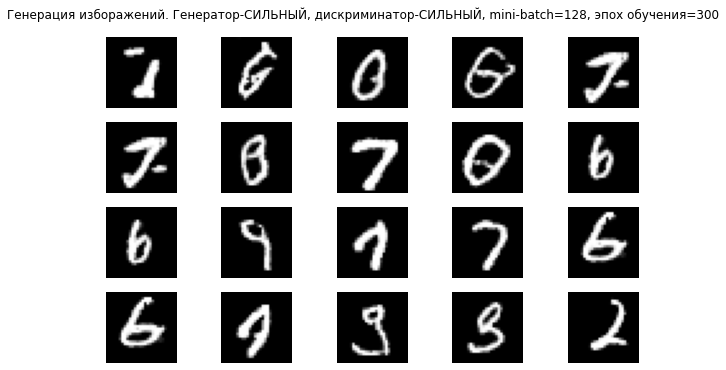

In [ ]:
mini_batch=128
epochs=300
gan=MyGan(image_shape=img_shape,generator_type='strong',disciminator_type='strong', latent_dim=latent_dim)
gan.compile(optimizers={ \
                "discriminator_optimizer":tf.keras.optimizers.Adam(learning_rate=0.0003), \
                'generator_optimizer':tf.keras.optimizers.Adam(learning_rate=0.0003)}, \
            loss = {"generator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False), \
                   "discriminator_loss_fn": tf.keras.losses.BinaryCrossentropy(from_logits=False)}, \
            metrics = {"generator_loss": tf.keras.metrics.Accuracy(), "discriminator_loss": tf.keras.metrics.Accuracy()})
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=epochs)

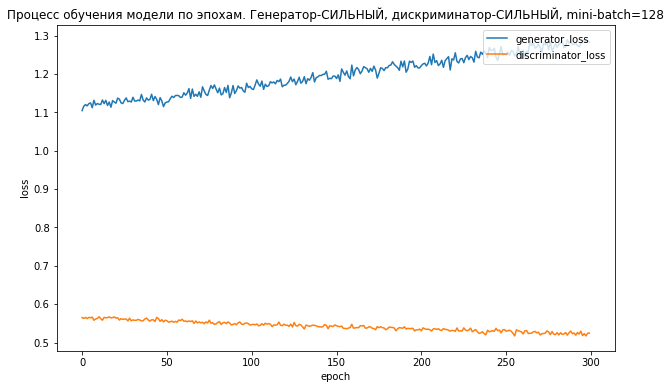

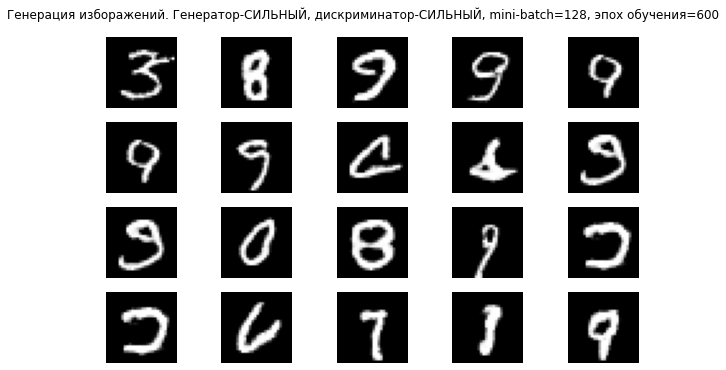

In [ ]:
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=900)

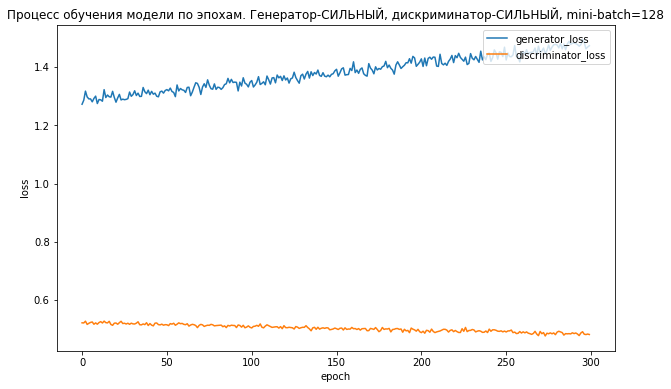

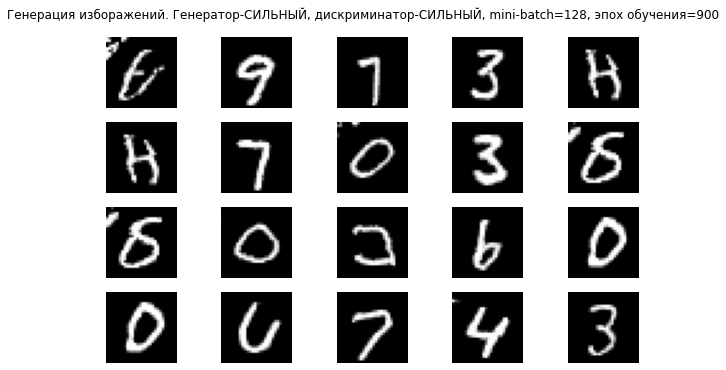

In [ ]:
history= gan.fit(dataset.take(mini_batch), epochs=epochs, verbose=False)
plot_history(history=history, generator_type='СИЛЬНЫЙ', discriminator_type='СИЛЬНЫЙ', batch_size=mini_batch, epochs=900)